In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import json
from PIL import Image
import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp002'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


In [5]:
# waypointを補正したdataset
root_dir = Path('../../input/')
train_df = pd.read_csv(root_dir / "baseline_locations_train.csv")
test_df = pd.read_csv(root_dir / "baseline_locations_test.csv")
sub_df = pd.read_csv(root_dir / 'sample_submission.csv', index_col=0)

In [6]:
train_df.shape, test_df.shape

((131342, 7), (91486, 7))

In [7]:
import glob
import os
from tqdm.notebook import tqdm


def get_ground_truth(args):
    (collectionName, phoneName), df = args
    
    path = root_dir / f"train/{collectionName}/{phoneName}/ground_truth.csv"
    target_df = pd.read_csv(path)
    output_df = pd.DataFrame()
    # merge derived and target by 'millisSinceGpsEpoch'
    for epoch, epoch_df in df.groupby('millisSinceGpsEpoch'):
        idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
        epoch_diff = epoch - target_df.loc[idx, 'millisSinceGpsEpoch']
        epoch_df['epoch_diff'] = epoch_diff
        epoch_df['target_latDeg'] = target_df.loc[idx, 'latDeg']
        epoch_df['target_lngDeg'] = target_df.loc[idx, 'lngDeg']
        output_df = pd.concat([output_df, epoch_df]).reset_index(drop=True)    
    return output_df

In [8]:
import multiprocessing

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    gr = train_df.groupby(['collectionName','phoneName'])
    dfs = pool.imap_unordered(get_ground_truth, gr)
    dfs = tqdm(dfs, total=len(gr))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

  0%|          | 0/73 [00:00<?, ?it/s]

In [9]:
# metric
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [10]:
train_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132
...,...,...,...,...,...,...,...,...,...,...
2365,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
2366,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
2367,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613
2368,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613


In [11]:
train_df['distance'] = calc_haversine(train_df['latDeg'],train_df['lngDeg'],train_df['target_latDeg'], train_df['target_lngDeg'])
train_df

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg,distance
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,3.586842
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,2.745901
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,1.888409
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,1.213483
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,1.650722
...,...,...,...,...,...,...,...,...,...,...,...
2365,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,2.052491
2366,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,2.671673
2367,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,2.287458
2368,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,3.454306


<AxesSubplot:>

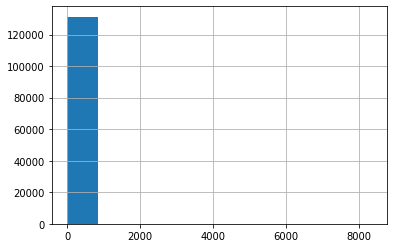

In [12]:
train_df['distance'].hist()

In [82]:
dfs = pd.DataFrame()
for (collectionName, phoneName), df in train_df.groupby(['collectionName','phoneName']):
    
    df['target_delta'] = calc_haversine(df['target_latDeg'], df['target_lngDeg'], df['target_latDeg'].shift(1), df['target_lngDeg'].shift(1))
    df['delta'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg'].shift(1), df['lngDeg'].shift(1))
    df['time_delta'] = df['millisSinceGpsEpoch'] - df['millisSinceGpsEpoch'].shift(1)
    

    if df['target_delta'].isna().sum() == 1:
        df['target_delta'].fillna(0, inplace=True)
        df['delta'].fillna(0, inplace=True)
        df['time_delta'].fillna(0, inplace=True)
    else:
        print('error')
    df['target_speed'] = df['target_delta'] / (df['time_delta']/1000)
    df['speed'] = df['delta'] / (df['time_delta']/1000)  # m/s
    dfs = pd.concat([dfs, df]).reset_index(drop=True)

In [83]:
dfs

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,epoch_diff,target_latDeg,target_lngDeg,distance,target_delta,delta,time_delta,target_speed,speed
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,3.586842,0.000000,0.000000,0.0,NaN,NaN
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,2.745901,0.000154,0.888202,1000.0,0.000154,0.888202
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,1.888409,0.001194,1.001204,1000.0,0.001194,1.001204
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,1.213483,0.001275,1.370528,1000.0,0.001275,1.370528
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,0,37.423576,-122.094132,1.650722,0.001109,0.741296,1000.0,0.001109,0.741296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131337,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,2.052491,0.000556,0.941490,1000.0,0.000556,0.941490
131338,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,2.671673,0.000556,2.011345,1000.0,0.000556,2.011345
131339,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,2.287458,0.000236,2.447052,1000.0,0.000236,2.447052
131340,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,0,37.334475,-121.899613,3.454306,0.004821,1.303535,1000.0,0.004821,1.303535


<AxesSubplot:>

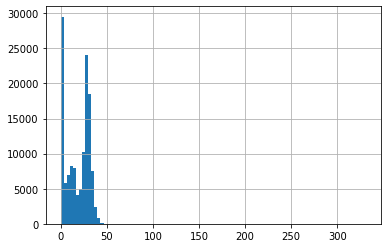

In [55]:
fig = plt.figure()
ax = fig.add_subplot()
dfs["target_delta"].hist(bins=100, ax=ax)

(0.0, 3.0)

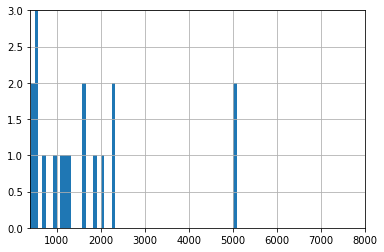

In [56]:
fig = plt.figure()
ax = fig.add_subplot()
dfs["delta"].hist(bins=100, ax=ax)
ax.set_xlim(400, 8000)
ax.set_ylim(0, 3)

<AxesSubplot:>

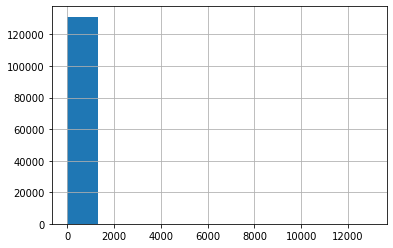

In [57]:
fig = plt.figure()
ax = fig.add_subplot()
dfs["time_delta"].hist(bins=10, ax=ax)

In [58]:
dfs['time_delta'].sort_values().tail(20)

124980     2089.0
89853      2657.0
93180      2772.0
60241      2781.0
89805      2781.0
5457       2792.0
5362       2794.0
32003      3000.0
117762     3000.0
41022      3000.0
65575      3000.0
52005      3000.0
7716       4000.0
119647     4000.0
5265       7000.0
5268       8000.0
5273       9000.0
67394     11000.0
67555     11000.0
67479     13000.0
Name: time_delta, dtype: float64

<AxesSubplot:>

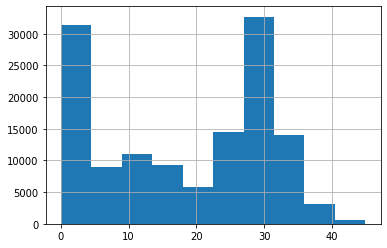

In [60]:
fig = plt.figure()
ax = fig.add_subplot()
dfs["target_speed"].hist(ax=ax)

<AxesSubplot:>

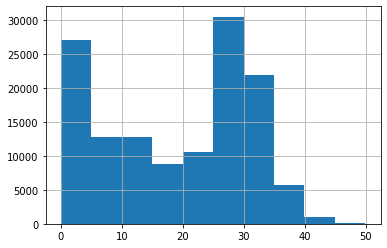

In [65]:
fig = plt.figure()
ax = fig.add_subplot()
dfs.loc[dfs["speed"]<50, 'speed'].hist(ax=ax)

Text(0, 0.5, 'count')

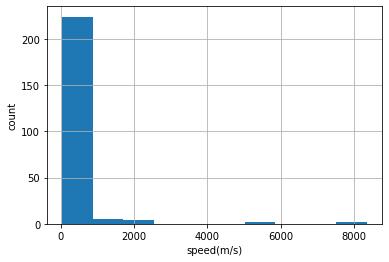

In [67]:

fig = plt.figure()
ax = fig.add_subplot()
dfs.loc[50<dfs["speed"], 'speed'].hist(ax=ax)
ax.set_xlabel('speed(m/s)')
ax.set_ylabel('count')

<AxesSubplot:>

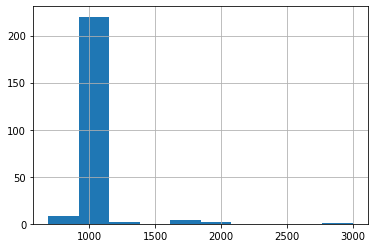

In [70]:
dfs.loc[50<dfs["speed"], 'time_delta'].hist()

In [72]:
dfs['distance'].mean()

3.846848374995186

In [74]:
dfs.loc[50>dfs['speed'],'distance'].mean()

3.5608174124992553

## testはどうだろう？

In [85]:
dfs = pd.DataFrame()
for (collectionName, phoneName), df in test_df.groupby(['collectionName','phoneName']):
  
    df['delta'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg'].shift(1), df['lngDeg'].shift(1))
    df['time_delta'] = df['millisSinceGpsEpoch'] - df['millisSinceGpsEpoch'].shift(1)
    df['delta'].fillna(0, inplace=True)
    df['time_delta'].fillna(0, inplace=True)
    df['speed'] = df['delta'] / (df['time_delta']/1000)  # m/s
    df['speed'].fillna(0, inplace=True)
    dfs = pd.concat([dfs, df]).reset_index(drop=True)

In [86]:
dfs

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,delta,time_delta,speed
0,2020-05-15-US-MTV-1,Pixel4,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Pixel4,0.000000,0.0,0.000000
1,2020-05-15-US-MTV-1,Pixel4,1273608786432,37.416646,-122.082040,-31.76,2020-05-15-US-MTV-1_Pixel4,2.314801,1000.0,2.314801
2,2020-05-15-US-MTV-1,Pixel4,1273608787432,37.416652,-122.082039,-31.65,2020-05-15-US-MTV-1_Pixel4,0.720397,1000.0,0.720397
3,2020-05-15-US-MTV-1,Pixel4,1273608788432,37.416607,-122.082063,-31.52,2020-05-15-US-MTV-1_Pixel4,5.475268,1000.0,5.475268
4,2020-05-15-US-MTV-1,Pixel4,1273608789432,37.416609,-122.082073,-28.95,2020-05-15-US-MTV-1_Pixel4,0.883032,1000.0,0.883032
...,...,...,...,...,...,...,...,...,...,...
91481,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763185000,37.334539,-121.899383,-8.39,2021-04-29-US-SJC-3_SamsungS20Ultra,1.048893,1000.0,1.048893
91482,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763186000,37.334545,-121.899380,-7.36,2021-04-29-US-SJC-3_SamsungS20Ultra,0.758992,1000.0,0.758992
91483,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763187000,37.334551,-121.899371,-4.08,2021-04-29-US-SJC-3_SamsungS20Ultra,1.053741,1000.0,1.053741
91484,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763188000,37.334540,-121.899371,-5.70,2021-04-29-US-SJC-3_SamsungS20Ultra,1.233520,1000.0,1.233520


<AxesSubplot:>

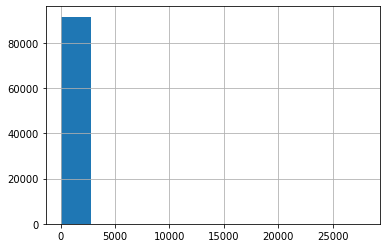

In [81]:
dfs['time_delta'].hist()

<AxesSubplot:>

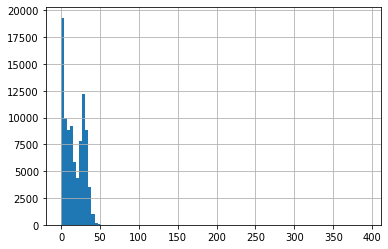

In [88]:
fig = plt.figure()
ax = fig.add_subplot()
dfs["delta"].hist(bins=100, ax=ax)
# ax.set_xlim(400, 8000)
# ax.set_ylim(0, 3)

Text(0, 0.5, 'count')

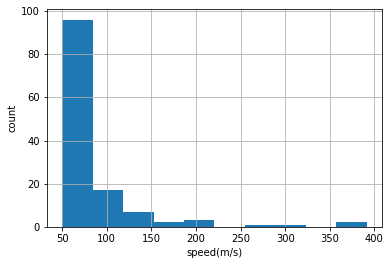

In [89]:

fig = plt.figure()
ax = fig.add_subplot()
dfs.loc[50<dfs["speed"], 'speed'].hist(ax=ax)
ax.set_xlabel('speed(m/s)')
ax.set_ylabel('count')

Text(0, 0.5, 'count')

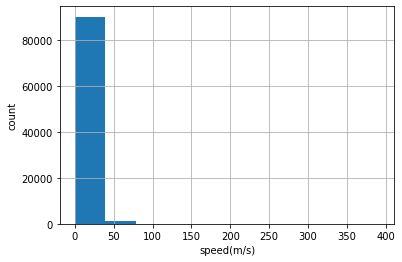

In [90]:

fig = plt.figure()
ax = fig.add_subplot()
dfs["speed"].hist(ax=ax)
ax.set_xlabel('speed(m/s)')
ax.set_ylabel('count')

speedはtrainもtestも50m/s以上のものが存在してた。これは異常なのでこれを線形補間する。

In [102]:
dfs = pd.DataFrame()
for (collectionName, phoneName), df in train_df.groupby(['collectionName','phoneName']):
  
    df['delta'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg'].shift(1), df['lngDeg'].shift(1))
    df['time_delta'] = df['millisSinceGpsEpoch'] - df['millisSinceGpsEpoch'].shift(1)
    df['delta'].fillna(0, inplace=True)
    df['time_delta'].fillna(0, inplace=True)
    df['speed'] = df['delta'] / (df['time_delta']/1000)  # m/s
    df['speed'].fillna(0, inplace=True)
    
    # 一度欠損値にする
    df.loc[50<df['speed'], ['latDeg', 'lngDeg']] = np.nan
    df['dummy_datetime'] = pd.to_datetime(df['millisSinceGpsEpoch'])
    df = df.set_index('dummy_datetime')
    
    # 時間に合わせて線形補間
    df = df.interpolate(method='time').reset_index(drop=True)
    dfs = pd.concat([dfs, df]).reset_index(drop=True)

In [103]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131342 entries, 0 to 131341
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   collectionName              131342 non-null  object 
 1   phoneName                   131342 non-null  object 
 2   millisSinceGpsEpoch         131342 non-null  int64  
 3   latDeg                      131342 non-null  float64
 4   lngDeg                      131342 non-null  float64
 5   heightAboveWgs84EllipsoidM  131342 non-null  float64
 6   phone                       131342 non-null  object 
 7   epoch_diff                  131342 non-null  int64  
 8   target_latDeg               131342 non-null  float64
 9   target_lngDeg               131342 non-null  float64
 10  distance                    131342 non-null  float64
 11  delta                       131342 non-null  float64
 12  time_delta                  131342 non-null  float64
 13  speed         

In [105]:
dfs['distance'] = calc_haversine(dfs['latDeg'],dfs['lngDeg'],dfs['target_latDeg'], dfs['target_lngDeg'])
dfs['distance'].mean()

3.6084284244593343

In [ ]:

dfs = pd.DataFrame()
for (collectionName, phoneName), df in test_df.groupby(['collectionName','phoneName']):
  
    df['delta'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg'].shift(1), df['lngDeg'].shift(1))
    df['time_delta'] = df['millisSinceGpsEpoch'] - df['millisSinceGpsEpoch'].shift(1)
    df['delta'].fillna(0, inplace=True)
    df['time_delta'].fillna(0, inplace=True)
    df['speed'] = df['delta'] / (df['time_delta']/1000)  # m/s
    df['speed'].fillna(0, inplace=True)
    
    # 一度欠損値にする
    df.loc[50<df['speed'], ['latDeg', 'lngDeg']] = np.nan
    df['dummy_datetime'] = pd.to_datetime(df['millisSinceGpsEpoch'])
    df = df.set_index('dummy_datetime')
    
    # 時間に合わせて線形補間
    df = df.interpolate(method='time').reset_index(drop=True)
    dfs = pd.concat([dfs, df]).reset_index(drop=True)